In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =294

ng =7

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 4 , 3 /) 

data wgt
     &     /0.4 , 0.5 , 0.6 , 0.7,
     &     0.85 , 0.9 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

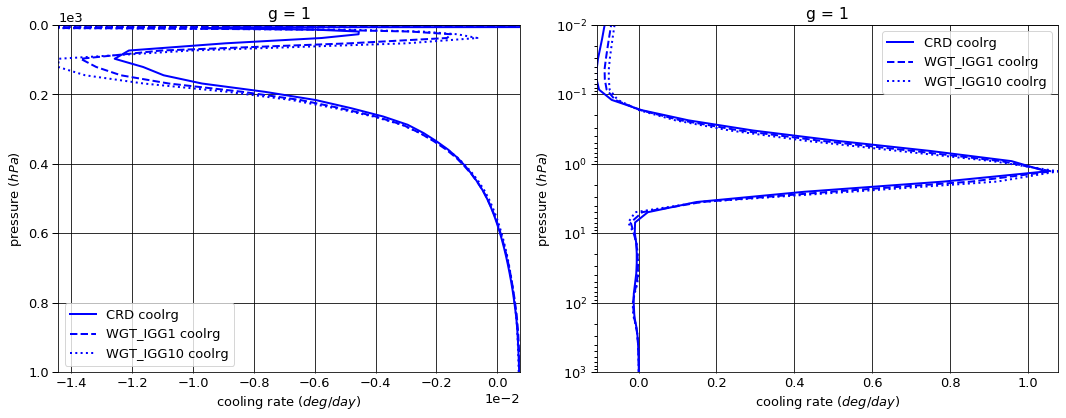

# Figure: cooling rate g-group 2

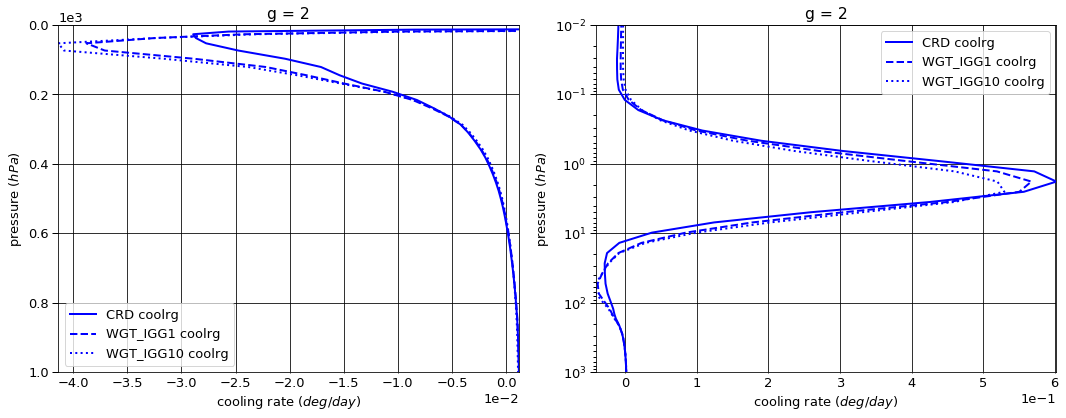

# Figure: cooling rate g-group 3

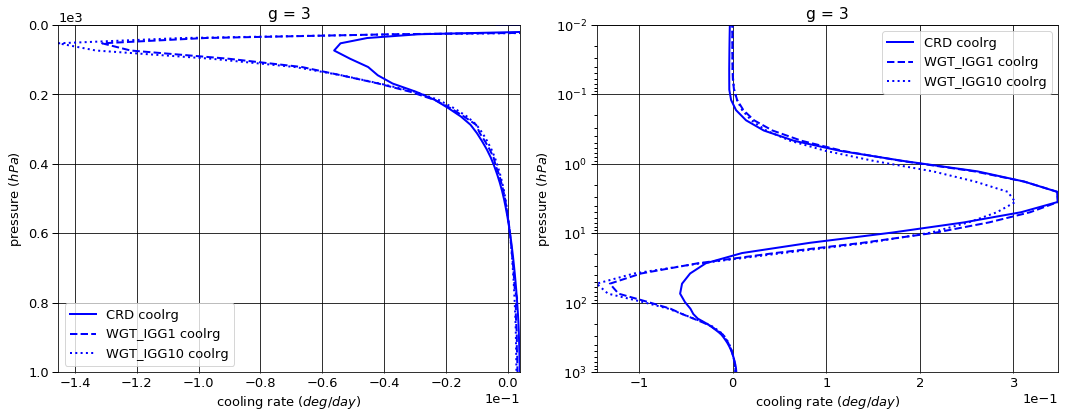

# Figure: cooling rate g-group 4

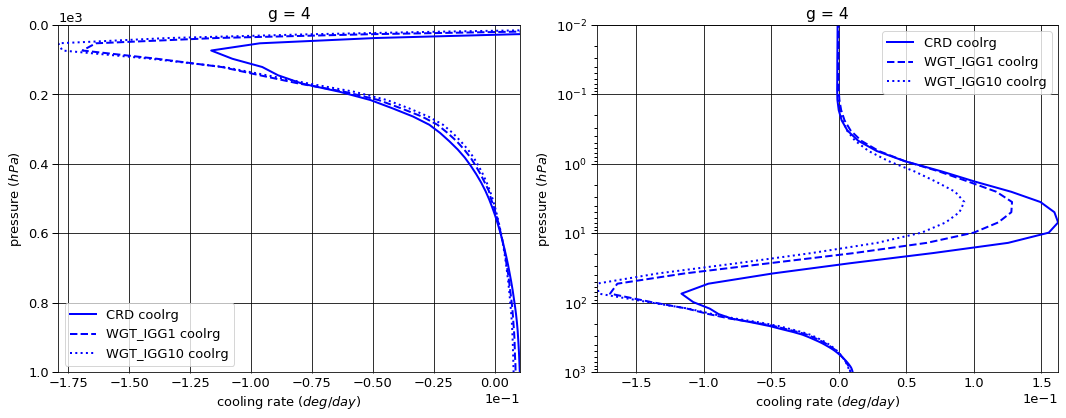

# Figure: cooling rate g-group 5

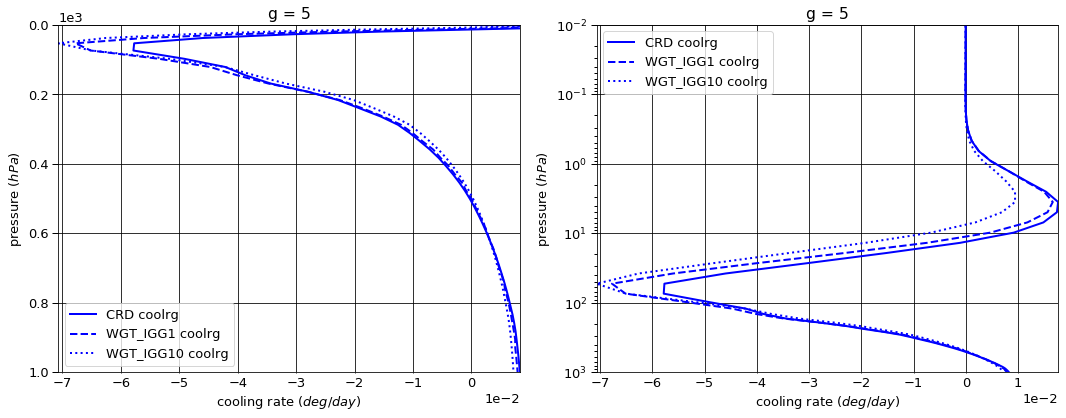

# Figure: cooling rate g-group 6

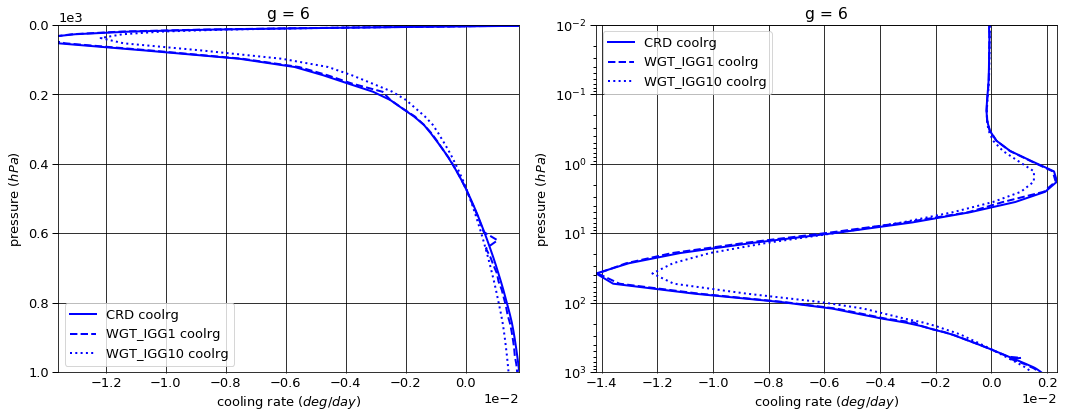

# Figure: cooling rate g-group 7

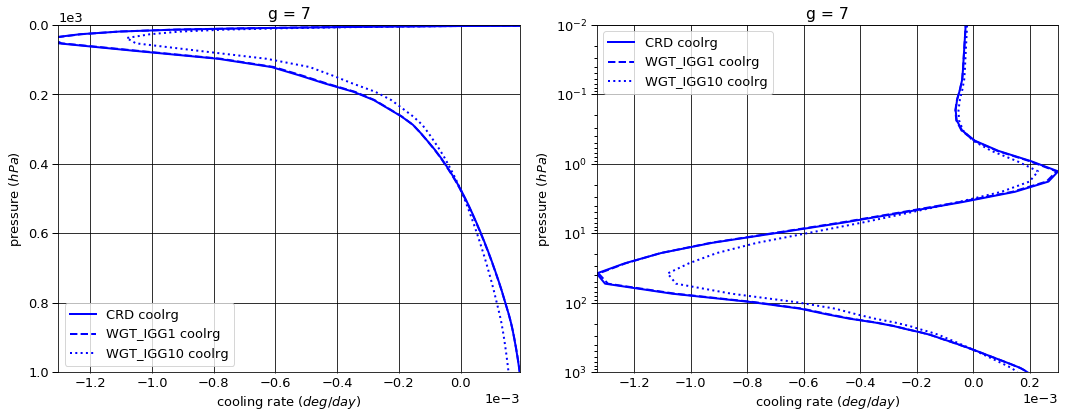

# Figure: cooling rate g-group total

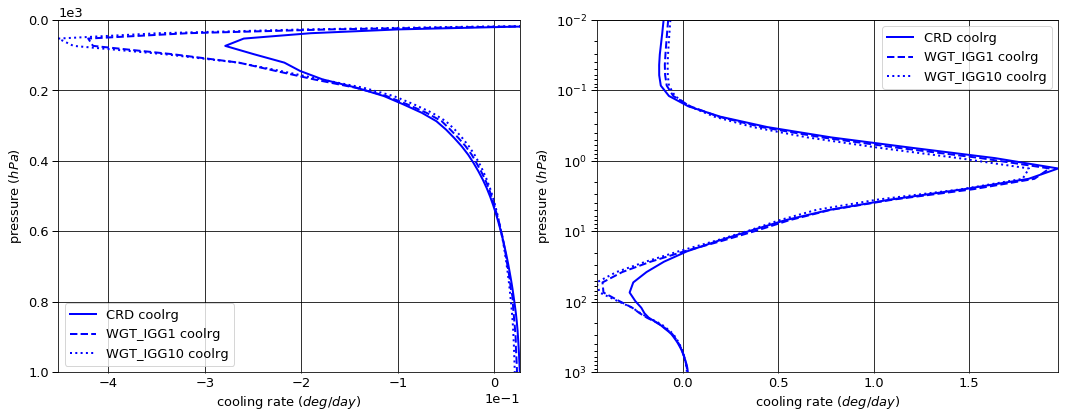

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.225191  0.000000 -0.225191
  1013.0   76    -0.411074  0.148551 -0.262523
2 0.0      1     -0.379994  0.000000 -0.379994
  1013.0   76    -0.848047  0.271916 -0.576132
3 0.0      1     -1.704366  0.000000 -1.704366
  1013.0   76    -3.255355  0.798890 -2.456465
4 0.0      1     -4.586312  0.000000 -4.586312
  1013.0   76    -8.233851  1.808464 -6.425388
5 0.0      1     -4.704103  0.000000 -4.704103
  1013.0   76    -6.749664  1.123358 -5.626306
6 0.0      1     -7.400426  0.000000 -7.400426
  1013.0   76    -7.740576  0.196842 -7.543734
7 0.0      1     -4.081160  0.000000 -4.081160
  1013.0   76    -4.115670  0.019738 -4.095931


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.230233  0.000000 -0.230233
  1013.0   76    -0.411074  0.150092 -0.260982
2 0.0      1     -0.341472  0.000000 -0.341472
  1013.0   76    -0.848047  0.265908 -0.582139
3 0.0      1     -1.101305  0.000000 -1.101305
  1013.0   76    -3.255355  0.833921 -2.421433
4 0.0      1     -3.927586  0.000000 -3.927586
  1013.0   76    -8.233851  1.783428 -6.450424
5 0.0      1     -4.618928  0.000000 -4.618928
  1013.0   76    -6.749664  1.110609 -5.639056
6 0.0      1     -7.407294  0.000000 -7.407294
  1013.0   76    -7.740576  0.190376 -7.550200
7 0.0      1     -4.081254  0.000000 -4.081254
  1013.0   76    -4.115670  0.019772 -4.095898


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.233796  0.000000 -0.233796
  1013.0   76    -0.411074  0.144441 -0.266632
2 0.0      1     -0.337415  0.000000 -0.337415
  1013.0   76    -0.848047  0.253210 -0.594837
3 0.0      1     -1.025490  0.000000 -1.025490
  1013.0   76    -3.255355  0.809481 -2.445874
4 0.0      1     -3.871197  0.000000 -3.871197
  1013.0   76    -8.233851  1.707114 -6.526737
5 0.0      1     -4.717612  0.000000 -4.717612
  1013.0   76    -6.749664  1.019213 -5.730451
6 0.0      1     -7.461915  0.000000 -7.461915
  1013.0   76    -7.740576  0.158129 -7.582447
7 0.0      1     -4.087783  0.000000 -4.087783
  1013.0   76    -4.115670  0.015999 -4.099671


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.042070e-03  0.000000 -0.005042
  1013.0   76     0.000000e+00  0.001541  0.001541
2 0.0      1      3.852169e-02  0.000000  0.038522
  1013.0   76     0.000000e+00 -0.006007 -0.006007
3 0.0      1      6.030609e-01  0.000000  0.603061
  1013.0   76     0.000000e+00  0.035032  0.035032
4 0.0      1      6.587265e-01  0.000000  0.658727
  1013.0   76     0.000000e+00 -0.025036 -0.025036
5 0.0      1      8.517510e-02  0.000000  0.085175
  1013.0   76    -8.881784e-16 -0.012750 -0.012750
6 0.0      1     -6.867800e-03  0.000000 -0.006868
  1013.0   76     0.000000e+00 -0.006467 -0.006466
7 0.0      1     -9.370000e-05  0.000000 -0.000094
  1013.0   76     0.000000e+00  0.000033  0.000033


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -8.605900e-03  0.000000 -0.008606
  1013.0   76     0.000000e+00 -0.004110 -0.004110
2 0.0      1      4.257820e-02  0.000000  0.042578
  1013.0   76     0.000000e+00 -0.018706 -0.018706
3 0.0      1      6.788760e-01  0.000000  0.678876
  1013.0   76     0.000000e+00  0.010591  0.010591
4 0.0      1      7.151155e-01  0.000000  0.715115
  1013.0   76     0.000000e+00 -0.101349 -0.101349
5 0.0      1     -1.350890e-02  0.000000 -0.013509
  1013.0   76    -8.881784e-16 -0.104145 -0.104145
6 0.0      1     -6.148870e-02  0.000000 -0.061489
  1013.0   76     0.000000e+00 -0.038713 -0.038713
7 0.0      1     -6.623200e-03  0.000000 -0.006623
  1013.0   76     0.000000e+00 -0.003739 -0.003739

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.040433
  1001.112500 75     0.000718
2 0.000312    1     -0.003763
  1001.112500 75     0.001199
3 0.000312    1     -0.001096
  1001.112500 75     0.003916
4 0.000312    1     -0.000288
  1001.112500 75     0.010356
5 0.000312    1     -0.000008
  1001.112500 75     0.008277
6 0.000312    1     -0.000021
  1001.112500 75     0.001791
7 0.000312    1     -0.000009
  1001.112500 75     0.000192


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.026930
  1001.112500 75     0.000738
2 0.000312    1     -0.002347
  1001.112500 75     0.001202
3 0.000312    1     -0.000251
  1001.112500 75     0.003172
4 0.000312    1     -0.000099
  1001.112500 75     0.008606
5 0.000312    1     -0.000007
  1001.112500 75     0.007896
6 0.000312    1     -0.000020
  1001.112500 75     0.001720
7 0.000312    1     -0.000009
  1001.112500 75     0.000192


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.023426
  1001.112500 75     0.000702
2 0.000312    1     -0.001413
  1001.112500 75     0.001114
3 0.000312    1     -0.000136
  1001.112500 75     0.002823
4 0.000312    1     -0.000110
  1001.112500 75     0.007790
5 0.000312    1     -0.000008
  1001.112500 75     0.007190
6 0.000312    1     -0.000018
  1001.112500 75     0.001432
7 0.000312    1     -0.000007
  1001.112500 75     0.000156


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.350264e-02
  1001.112500 75     2.050763e-05
2 0.000312    1      1.416170e-03
  1001.112500 75     3.060100e-06
3 0.000312    1      8.449480e-04
  1001.112500 75    -7.439172e-04
4 0.000312    1      1.890494e-04
  1001.112500 75    -1.750040e-03
5 0.000312    1      1.105002e-06
  1001.112500 75    -3.813037e-04
6 0.000312    1      8.820590e-07
  1001.112500 75    -7.048110e-05
7 0.000312    1      6.346310e-08
  1001.112500 75     4.489500e-07


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.700683e-02
  1001.112500 75    -1.563546e-05
2 0.000312    1      2.349865e-03
  1001.112500 75    -8.465540e-05
3 0.000312    1      9.604523e-04
  1001.112500 75    -1.092482e-03
4 0.000312    1      1.781295e-04
  1001.112500 75    -2.566294e-03
5 0.000312    1      3.881515e-07
  1001.112500 75    -1.086763e-03
6 0.000312    1      3.140972e-06
  1001.112500 75    -3.582738e-04
7 0.000312    1      1.723278e-06
  1001.112500 75    -3.613552e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.081552,0.000000,-23.081552
1013.0,76,-31.354237,4.367759,-26.986478



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.708071,0.000000,-21.708071
1013.0,76,-31.354237,4.354105,-27.000132



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.735209,0.000000,-21.735209
1013.0,76,-31.354237,4.107587,-27.246650



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.373481,0.000000,1.373481
1013.0,76,0.000000,-0.013654,-0.013654



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.346343,0.000000,1.346343
1013.0,76,0.000000,-0.260171,-0.260171


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.045618
1001.112500,75,0.026448



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.029663
1001.112500,75,0.023526



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.025118
1001.112500,75,0.021208



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.015955
1001.112500,75,-0.002922



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.020501
1001.112500,75,-0.005240


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.013083,0.013101
2,0.026792,0.027120
3,0.102833,0.104146
4,0.259042,0.263859
5,0.212917,0.216035
6,0.245292,0.247839
7,0.140042,0.127900


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310613e-18
2,2.305341e-19
3,2.300081e-20
4,2.294833e-21
5,1.127464e-20
6,1.127564e-21
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310613e-18,NaN,0.013083,0.013101,0.013083,0.013101,1.0
2,2.305341e-19,0.099772,0.026792,0.027120,0.039875,0.040221,1.0
3,2.300081e-20,0.099772,0.102833,0.104146,0.142708,0.144366,1.0
4,2.294833e-21,0.099772,0.259042,0.263859,0.401750,0.408226,1.0
5,1.127464e-20,4.913053,0.212917,0.216035,0.614667,0.624261,50.0
6,1.127564e-21,0.100009,0.245292,0.247839,0.859958,0.872100,50.0
7,1.127665e-22,0.100009,0.140042,0.127900,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     8.132598e-18  4.526583e-18   1.796631  8.552236e-06
      2 0.000312     5.155120e-19  2.801740e-19   1.839971  5.700206e-07
      3 0.000312     3.144259e-20  1.760406e-20   1.786099  3.711923e-08
      4 0.000312     2.486698e-21  1.153672e-21   2.155463  2.989907e-09
      5 0.000312     8.832331e-23  8.670654e-23   1.018646  1.262002e-10
      6 0.000312     1.069853e-22  8.407023e-23   1.272571  1.500030e-10
      7 0.000312     7.788626e-23  2.367747e-23   3.289467  1.115937e-10
2     1 0.000750     8.129584e-18  4.529855e-18   1.794668  3.864040e-06
      2 0.000750     5.167252e-19  2.809423e-19   1.839257  2.581533e-07
      3 0.000750     3.156206e-20  1.767303e-20   1.785888  1.683320e-08
      4 0.000750     2.495350e-21  1.159510e-21   2.152073  1.355771e-09
      5 0.000750     8.908089e-23  8.745693e-23   1.018569  5.750175e-11
      6 0.000750     1.074923e-22  8.449239e-23   1.272212  6.808784e-11
      7 0.000750     7.805232e-23  2.374672e-23   3.286867  5.052095e-11
3     1 0.001052     8.123432e-18  4.536705e-18   1.790602  6.592853e-06
      2 0.001052     5.192529e-19  2.825012e-19   1.838055  4.425973e-07
      3 0.001052     3.180511e-20  1.780005e-20   1.786799  2.893010e-08
      4 0.001052     2.511562e-21  1.168899e-21   2.148655  2.328227e-09
      5 0.001052     9.021566e-23  8.857733e-23   1.018496  9.933329e-11
      6 0.001052     1.085210e-22  8.533875e-23   1.271650  1.172555e-10
      7 0.001052     7.840250e-23  2.388644e-23   3.282302  8.656203e-11
4     1 0.001476     8.116838e-18  4.543912e-18   1.786310  1.090835e-05
      2 0.001476     5.219428e-19  2.841677e-19   1.836742  7.360802e-07
      3 0.001476     3.206656e-20  1.793828e-20   1.787605  4.824088e-08
      4 0.001476     2.529317e-21  1.179388e-21   2.144602  3.879576e-09
      5 0.001476     9.151295e-23  8.985913e-23   1.018405  1.666726e-10
      6 0.001476     1.096364e-22  8.625597e-23   1.271059  1.959538e-10
      7 0.001476     7.877991e-23  2.403642e-23   3.277522  1.438719e-10
5     1 0.002070     8.110126e-18  4.551083e-18   1.782021  1.763893e-05
      2 0.002070     5.246544e-19  2.858596e-19   1.835357  1.196428e-06
      3 0.002070     3.233371e-20  1.808255e-20   1.788116  7.862854e-08
      4 0.002070     2.547934e-21  1.190759e-21   2.139756  6.320164e-09
      5 0.002070     9.295991e-23  9.129031e-23   1.018289  2.737034e-10
      6 0.002070     1.107865e-22  8.720209e-23   1.270457  3.201088e-10
      7 0.002070     7.916527e-23  2.418948e-23   3.272715  2.337173e-10
6     1 0.002904     8.103275e-18  4.558216e-18   1.777730  2.804756e-05
      2 0.002904     5.273907e-19  2.875837e-19   1.833869  1.912410e-06
      3 0.002904     3.260765e-20  1.823496e-20   1.788194  1.260521e-07
      4 0.002904     2.567650e-21  1.203339e-21   2.133771  1.012956e-08
      5 0.002904     9.460983e-23  9.292422e-23   1.018140  4.428343e-10
      6 0.002904     1.119772e-22  8.818315e-23   1.269826  5.143622e-10
      7 0.002904     7.955902e-23  2.434635e-23   3.267800  3.733847e-10
7     1 0.004074     8.096243e-18  4.565317e-18   1.773424  4.400283e-05
      2 0.004074     5.301589e-19  2.893511e-19   1.832234  3.016280e-06
      3 0.004074     3.289019e-20  1.839858e-20   1.787648  1.994405e-07
      4 0.004074     2.588823e-21  1.217596e-21   2.126175  1.602864e-08
      5 0.004074     9.653878e-23  9.483701e-23   1.017944  7.087603e-10
      6 0.004074     1.132185e-22  8.920874e-23   1.269142  8.157481e-10
      7 0.004074     7.996219e-23  2.450828e-23   3.262660  5.886161e-10
8     1 0.005714     8.088973e-18  4.572396e-18   1.769088  6.828745e-05
      2 0.005714     5.329693e-19  2.911776e-19   1.830393  4.706359e-06
      3 0.005714     3.318390e-20  1.857771e-20   1.786222  3.122709e-07
      4 0.005714     2.611949e-21  1.234181e-21   2.116342  2.511078e-08
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
